In [87]:
# Für Imports (:P)
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import numpy as np

In [61]:
%matplotlib inline

## Overview of the steps

1. Camera calibration
1. Distortion correction
1. Color/gradient threshold
1. Perspective transform
1. Lane detection
1. Lane curvature calculation
1. Inverse perspective transform
1. Display of detected lane on the original image

## 1. Camera calibration

### 1.a Look at files for camera calibration

In [103]:
def calibration_files():
    return list(map(lambda x: 'camera_cal/' + x, os.listdir('./camera_cal')))

In [104]:
for file in calibration_files():
    print(file)

camera_cal/calibration1.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration2.jpg
camera_cal/calibration20.jpg
camera_cal/calibration3.jpg
camera_cal/calibration4.jpg
camera_cal/calibration5.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg


In [105]:
print(len(calibration_files()))

20


We have about 20 images for calliberation

In [82]:
def load_images(images):
    loaded_images = []
    
    for image in images:
        loaded_images.append(mpimg.imread(image))
        
    return loaded_images

In [83]:
def show_images(images, n_rows):
    n_images = len(images)
    n_cols = math.ceil(1.0 * n_images / n_rows)
    
    f, subplots = plt.subplots(n_rows, n_cols, figsize=(20, 9))
    f.tight_layout()
    subplots = subplots.flatten()
    
    for index, image in enumerate(images):
        subplots[index].imshow(image)

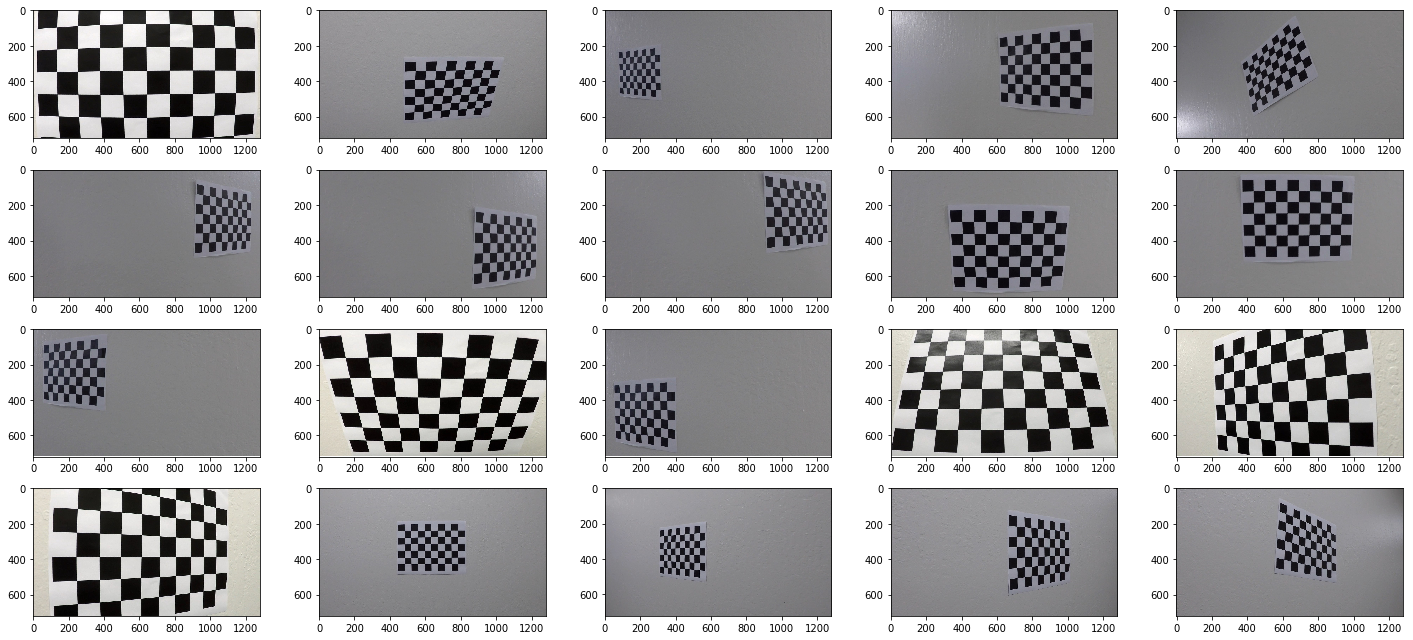

In [106]:
show_images(load_images(calibration_files()), 4)

#### Conclusion

We can see a bunch of chessboard images from different angles and thus distorted to different extent.

### 1.b Calibrate camera

In [113]:
def calibrate_camera(images):
    objpoints = []
    imgpoints = []
    
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        
        if ret:
            objp = np.zeros((9*6, 3), np.float32)
            objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
            
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, images[0].shape[0:2], None, None)
    
    return mtx, dist

## 2. Distortion correction

In [114]:
mtx, dst = calibrate_camera(load_images(calibration_files()))

In [122]:
def undistort_image(image, mtx, dst):
    return cv2.undistort(image, mtx, dst, None, mtx)

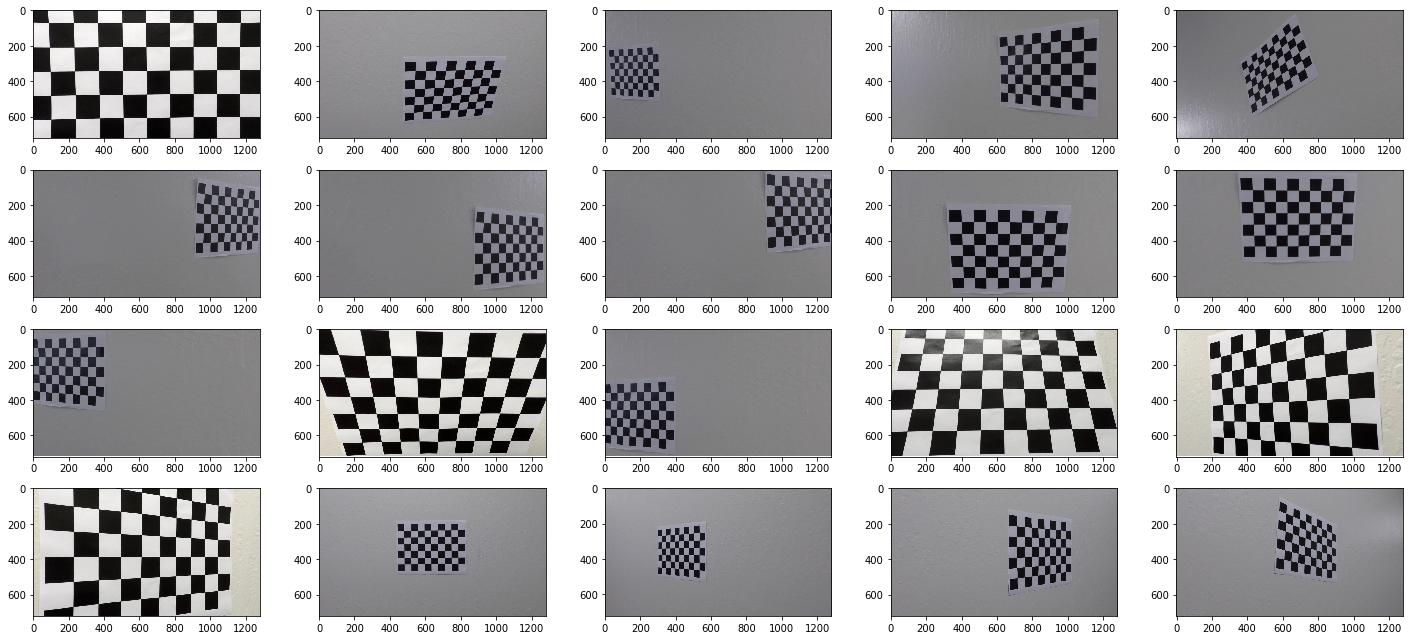

In [124]:
show_images(list(map(lambda x: undistort_image(x, mtx, dst), load_images(calibration_files()))), 4)

#### Observation

Images look pretty undistorted!

## 3. Color/gradient threshold

In [126]:
def grayscale_img(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [128]:
def display_binary(img):
    plt.imshow(img, cmap='gray')

### 3.a Sobel gradient

In [130]:
def sobel_x(g_img, thresh=(20, 100)):
    sobel = cv2.Sobel(g_img, cv2.CV_64F, 1, 0)
    abs_sobel = np.abs(sobel)
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_sobel

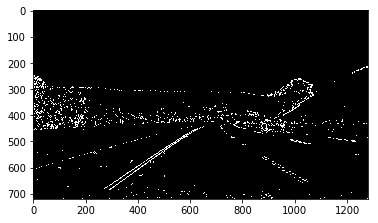

In [164]:
display_binary(sobel_x(grayscale_img(load_images(['./test_images/test3.jpg'])[0]), thresh=(20,100)))

### 3.b Color thresholding

In [135]:
def hls_img(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [138]:
def color_threshold(hls, thresh=(170,255)):
    s_channel = hls[:,:,2]
    binary_img = np.zeros_like(s_channel)
    
    binary_img[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_img

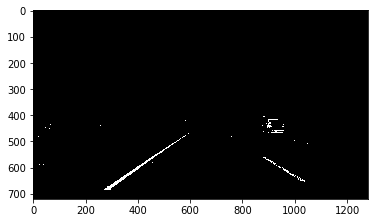

In [141]:
display_binary(color_threshold(hls_img(load_images(['./test_images/test3.jpg'])[0]), thresh=(170,255)))

### 3.c Combined thresholding

In [176]:
def combine_thresholds(*thresholds):
    # Initialize a binary image
    binary_img = np.zeros_like(thresholds[0])

    for img in thresholds:
        binary_img = binary_img | img
        
    return binary_img

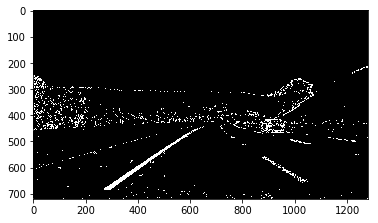

In [182]:
def test_thresholding():
    img = load_images(['./test_images/test3.jpg'])[0]
    g_img = grayscale_img(img)
    hls = hls_img(img)
    
    thresholds = [
        sobel_x(g_img, thresh=(20, 100)),
        color_threshold(hls, thresh=(170, 255))
    ]
    
    final_img = combine_thresholds(*thresholds)
    
    display_binary(final_img)

test_thresholding()